# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
import tensorflow as tf
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import multiprocessing

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=2048, d_hidden=4096):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z



2025-05-01 09:00:03.680769: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 09:00:03.701564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746090003.725349  775335 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746090003.733142  775335 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746090003.751857  775335 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load dataset and model (takes 45 seconds)

In [2]:
MODEL_ID = "google/paligemma-3b-mix-224"
TRAINING_DATASET = "imagenet-1k"
TRAINING_DATASET_SIZE = 5000

dtype = torch.float16
if torch.cuda.is_available():
    torch.cuda.set_device(1)  # Set current device to 1
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype
).eval()
model = model.to(device) # Move model to GPU
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Load dataset, shuffle, and select a subset
dataset = load_dataset(TRAINING_DATASET, split="train")
dataset = dataset.shuffle(seed=42).select(range(TRAINING_DATASET_SIZE))  # Only 500 images

# Set up activation capture (vision tower)
vision_acts = {}
def vision_hook(module, input, output):
    vision_acts["activation"] = output

hook_handle = model.vision_tower.vision_model.encoder.layers[20].register_forward_hook(vision_hook)

Using device: cuda:0


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [3]:
# === Config ===
BATCH_SIZE = 64 # max size withou OOM error
NUM_WORKERS = 8

# === Preprocess images (convert to RGB) ===
def preprocess(example):
    image = example["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    return {"image": image, "prompt": "<image> caption"}

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

dataset = dataset.map(
    preprocess,
    batched=False,
    num_proc=multiprocessing.cpu_count(),
    desc="Converting images to RGB"
)

# === Split dataset across 2 GPUs ===
half = len(dataset) // 2
datasets = [Subset(dataset, range(0, half)), Subset(dataset, range(half, len(dataset)))]
devices = ["cuda:0", "cuda:1"]
activation_lists = [[], []]
token_counts = [[], []]

# === Inference function ===
def run_inference(model, dataloader, device, activations_out, token_counts_out):
    model = model.to(device).eval()
    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            images = batch["images"]
            prompts = batch["prompts"]

            model_inputs = processor(
                text=prompts,
                images=images,
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=torch.bfloat16):
                _ = model(**model_inputs)

            act = vision_acts["activation"]
            if isinstance(act, tuple):
                act = act[0]

            activations_out.append(act.cpu().float())
            token_counts_out.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"Skipping batch due to error on {device}: {e}")
            continue

# === Run in parallel across both GPUs ===
from threading import Thread

dataloaders = [
    DataLoader(datasets[0], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True),
    DataLoader(datasets[1], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True)
]

# Clone model and hook separately for each GPU
import copy
models = [copy.deepcopy(model), copy.deepcopy(model)]

# Register hooks on both models (if needed)
hook_handles = []
for i, m in enumerate(models):
    h = m.vision_tower.vision_model.encoder.layers[20].register_forward_hook(
        lambda module, input, output: vision_acts.update({"activation": output})
    )
    hook_handles.append(h)

# Launch threads
threads = []
for i in range(2):
    t = Thread(target=run_inference, args=(
        models[i], dataloaders[i], devices[i], activation_lists[i], token_counts[i]))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# Remove hooks
for h in hook_handles:
    h.remove()

# === Merge results ===
all_activations = torch.cat(activation_lists[0] + activation_lists[1], dim=0)
image_to_token_counts = token_counts[0] + token_counts[1]

if all_activations.size(0) == 0:
    raise ValueError("No valid activations collected!")

print("✅ Collected activations:", all_activations.shape)
print("🧮 Sum of tokens recorded:", sum(image_to_token_counts))

# Clean up memory
del models, hook_handles, activation_lists, token_counts, datasets, dataloaders, vision_acts
gc.collect()
torch.cuda.empty_cache()


Inference on cuda:0:   0%|                                           | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_775335/1258887081.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=torch.bfloat16):
Inference on cuda:1: 100%|██████████████████████████████████| 40/40 [00:44<00:00,  1.11s/it]


✅ Collected activations: torch.Size([5000, 256, 1152])
🧮 Sum of tokens recorded: 1280000


### Save to disk

In [4]:
# Convert to half precision before saving (cuts size in half)
all_activations_fp16 = all_activations.half()

# Save to disk
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(image_to_token_counts, "image_to_token_counts.pt")

In [ ]:
# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-3,
    "n_epochs": 100,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to("cuda:0")  # ✅ First move to cuda:0
sae = nn.DataParallel(sae)  # ✅ Now wrap for multi-GPU
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# === Training loop ===
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to("cuda:0", non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save(sae.state_dict(), model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

Epoch 5: Loss 1.012221
Epoch 10: Loss 0.451052
Epoch 15: Loss 0.225476
Epoch 20: Loss 0.123877


### Visualize features

Top 5 active features: [345, 721, 1937, 2661, 115]


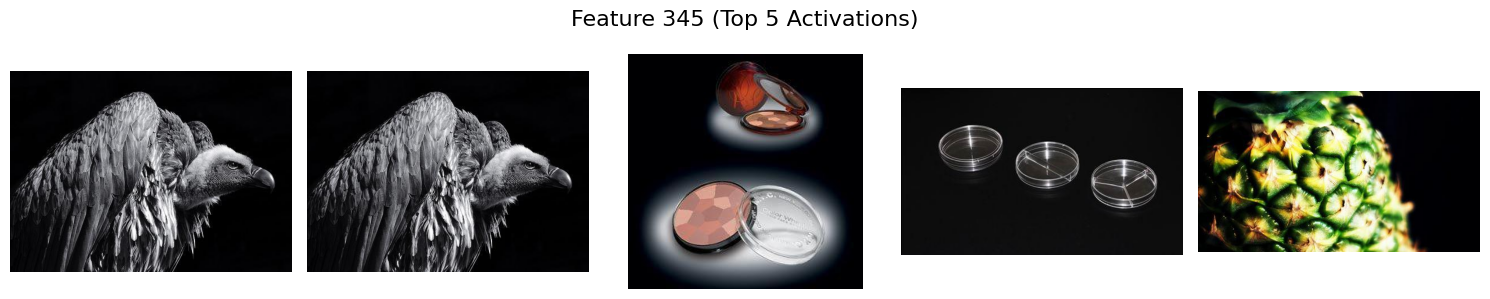

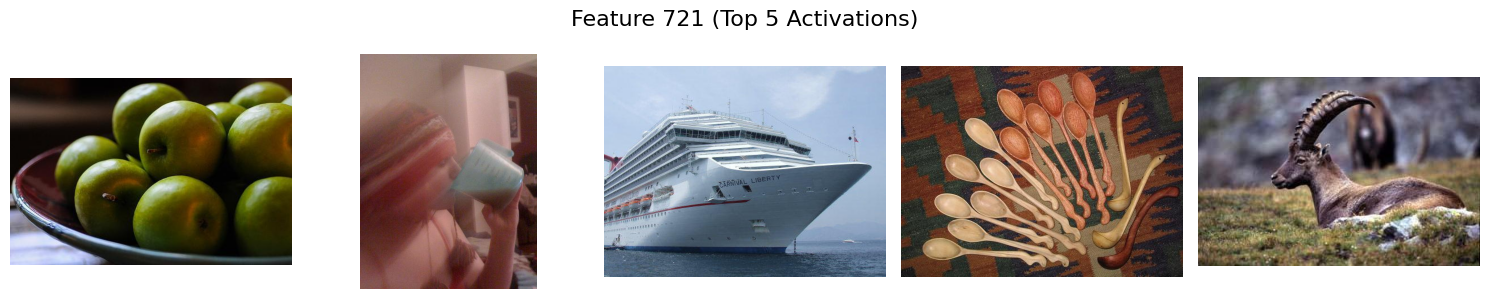

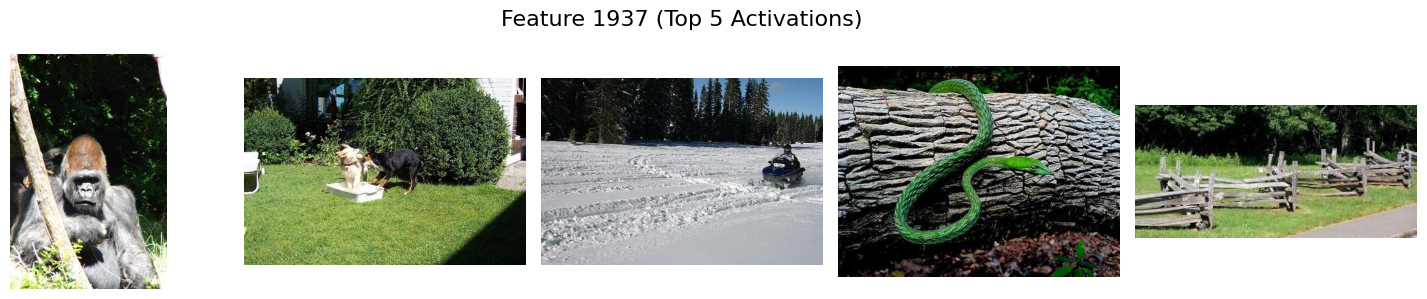

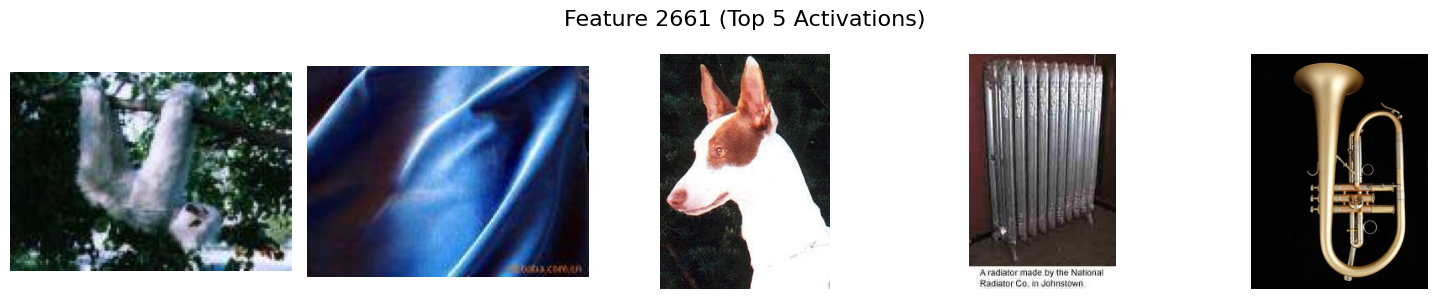

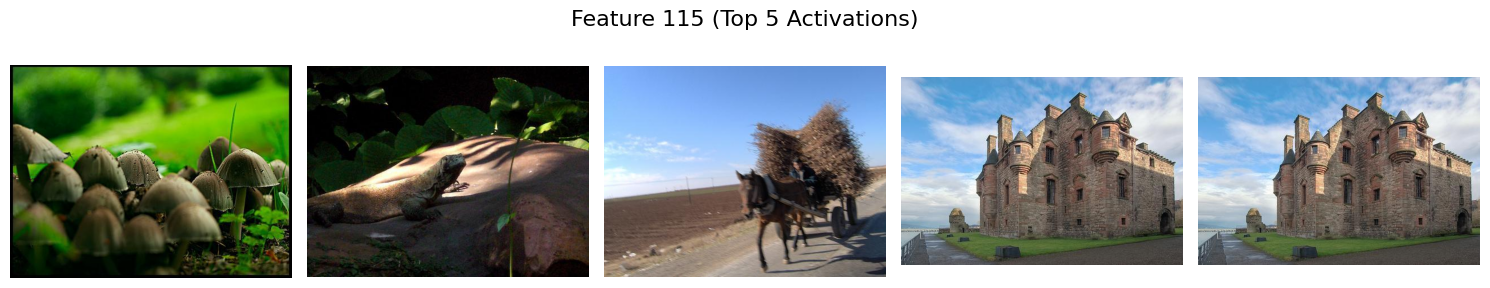

In [29]:
# ==== CONFIG ====
top_k = 5
n_features_to_plot = 5
batch_size = 4096  # tune based on your GPU memory
num_workers = 16    # number of parallel CPU threads

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)
del all_activations
torch.cuda.empty_cache()

# ==== TOKEN-TO-IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Mismatch: {len(image_indices_per_token)} vs {sparse_features.shape[0]}"

image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== PARALLEL IMAGE LOADING ====
def load_rgb(idx):
    img_idx = int(image_indices_per_token[idx])
    image = dataset[img_idx]["image"].convert("RGB")
    return np.array(image)

# ==== DISPLAY ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load top images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    # Plot
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
    axes = [axes] if top_k == 1 else axes
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=16)

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Sparsity analysis

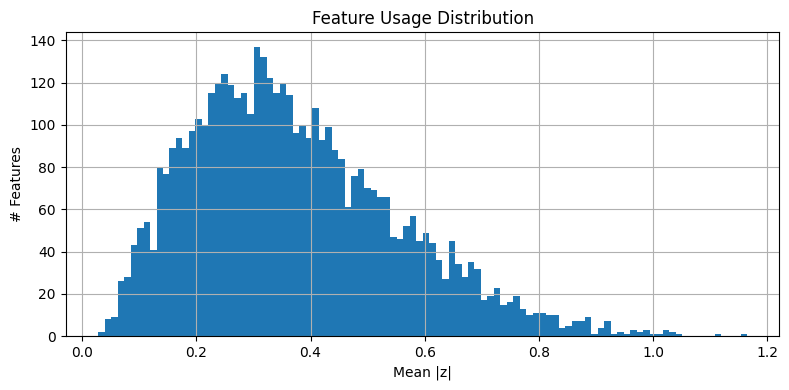

In [32]:
# Compute total number of tokens
total_tokens = sum(image_to_token_counts)
d_hidden = sae.encoder.out_features
z_all = torch.empty(total_tokens, d_hidden)

with torch.no_grad():
    i = 0
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)              # shape: [B, T, H]
        z = z.view(-1, z.shape[-1])    # flatten to [B*T, H]
        b = z.size(0)
        z_all[i:i+b] = z.cpu()
        i += b

# Compute feature usage
feature_usage = torch.mean(torch.abs(z_all), dim=0)

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clean up memory

In [12]:
# del [insert variable]
del dataset
torch.cuda.empty_cache()
gc.collect()

1615